# Sentiment Analysis on Twitter data

In [1]:
%%capture
!pip install datasets
!pip install transformers==4.28.1
!pip install emoji
!pip install clean-text

In [2]:
%%capture
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [3]:
%%capture
!pip install tqdm
!pip install matplotlib
!pip install seaborn

# Importing the necessary libraries

In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from transformers import BartForSequenceClassification, BartTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from datasets import Dataset

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from emoji import demojize
from tqdm.auto import tqdm
from IPython import display
import pprint
import json
import warnings
warnings.filterwarnings("ignore")

In [5]:
#fixed random seed - for reproducibility
SEED = 101
#checking for availability of GPU & assigning it to device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Loading and Analysing data

In [16]:
#Read the small dataset (csv file) into pandas dataframe
df=pd.read_csv('dataset_small_w_bart_preds.csv')
df.head(2)

,is_positive,id,datetime,user,message_clean,bart_is_positive
0,0,2323266775,Thu Jun 25 00:15:43 PDT 2009,gulti,had dream sneaked out escape into the,0.075236
1,1,2192626220,Tue Jun 16 07:18:56 PDT 2009,lpgrant,richmondgl murder train just cracked but you r...,0.003549


## 1. pie chart for sentiment distribution - to check for imbalance dataset

In [17]:
#Group the data by sentiment and count the number of messages for each category or label
class_df = df.groupby('is_positive').count()['message_clean'].reset_index().sort_values(by='message_clean',ascending=False)
class_df.style.background_gradient(cmap='binary')

,is_positive,message_clean
1,1,10088
0,0,9911


[None, None, None, None]

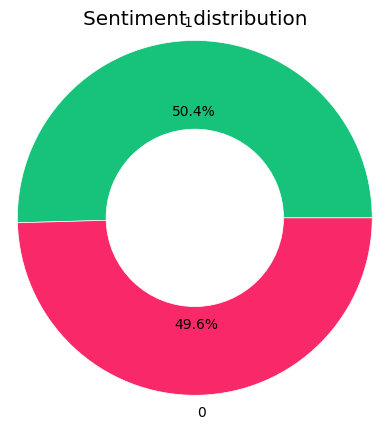

In [24]:
percent_class=class_df.message_clean
labels= class_df.is_positive
colors = ['#17C37B','#F92969']

#create a pie chart with percentage of messages for each category or label
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")
plt.title('Sentiment distribution')
plt.setp(my_pie, width=0.6, edgecolor='white')

## 2. Time series of sentiment over time

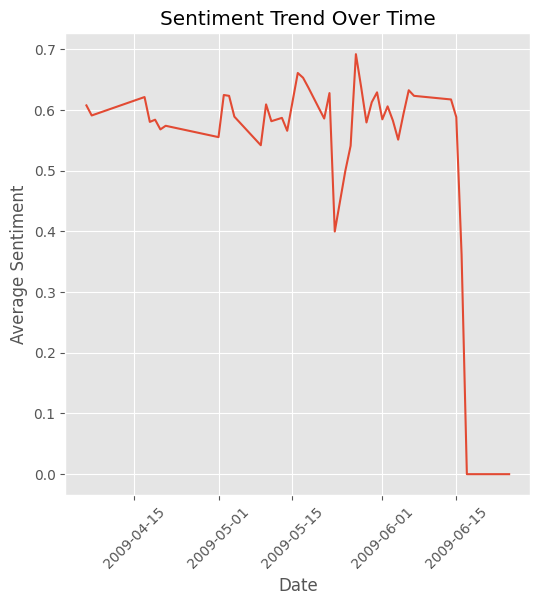

In [21]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Group the data by date and calculate the average sentiment
daily_sentiment = df.groupby(df['datetime'].dt.date)['is_positive'].mean()

# Create a line plot
plt.figure(figsize=(6, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values)
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Trend Over Time')
plt.xticks(rotation=45)
plt.show()

## 3. user distribution analysis

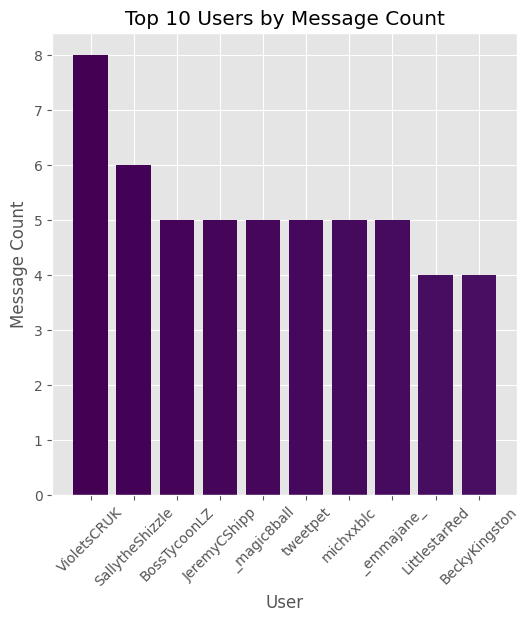

In [26]:
#extract the top 10 users with the highest message count
top_users = df['user'].value_counts().nlargest(10)

#create a colormap using cmap
cmap = plt.cm.get_cmap('viridis')

# Create a bar plot for user distribution
plt.figure(figsize=(6, 6))
plt.bar(top_users.index, top_users.values, color =cmap(np.arange(len(top_users))))
plt.xlabel('User')
plt.ylabel('Message Count')
plt.title('Top 10 Users by Message Count')
plt.xticks(rotation=45)
plt.show()

# EDA

In [27]:
#check for duplicate values
duplicate_id = df[df['id'].duplicated()]
duplicate_message = duplicate_id[duplicate_id['message_clean'].duplicated()]
len(duplicate_message)

0

In [28]:
duplicate_id 

,is_positive,id,datetime,user,message_clean,bart_is_positive
8488,0,1759542071,2009-05-10 19:26:37,wayneswan,well looks like got the numbers all wrong agai...,0.004558


In [29]:
#check for null values
df[df['message_clean'].isnull()]

,is_positive,id,datetime,user,message_clean,bart_is_positive
17097,1,1677293720,2009-05-02 01:20:56,twitnando,NaN,0.792777


In [30]:
df.dropna(inplace=True)

In [ ]:
#recheck
df[df['message_clean'].isnull()]

In [32]:
#select specific column that are more important or based on our requirement 
df = df[['is_positive', 'id', 'message_clean']]

In [33]:
df.head(2)

,is_positive,id,message_clean
0,0,2323266775,had dream sneaked out escape into the
1,1,2192626220,richmondgl murder train just cracked but you r...


# Preprocessing

In [35]:
#Preprocessing
#the smaller dataset is already preprocessed and its understandable by checking out the message_clean in the 
#dataframe. If we are using the whole dataset, the following preprocessing function can be used.

In [38]:
import re
from cleantext import clean

def text_preprocessing(text):
    #Remove username
    text = re.sub(r'@\w+', '<USER>', text)

    #Clean text
    text = clean(text,
        fix_unicode=True,
        to_ascii=True,
        lower=True,
        no_line_breaks=False,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=False,
        no_punct=False,
        replace_with_punct="",
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en"
    )

    return text.lower()

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [37]:
#Read the full dataset into pandas dataframe
df_full =pd.read_csv('twitter_dataset_full.csv')
df_full.head(2)

,is_positive,id,datetime,user,message
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...


In [39]:
#check the preprocessing with text message from full dataset.
text = df_full['message'].iloc[1]
preprocessed_text = text_preprocessing(text)
print('Original text message: ', text)
print('Preprocessed text message: ', preprocessed_text)

Original text message:  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Preprocessed text message:  <user> i dived many times for the ball. managed to save 50% the rest go out of bounds


# Training and evaluation

In [49]:
#split the dataframe into train and test sets.
train, test = train_test_split(df, test_size=0.2, stratify=df["is_positive"], random_state=SEED)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

#train['cleaned_message'] = train['message'].apply(preprocess_text)
#test['cleaned_message'] = test['message'].apply(preprocess_text)

(15999, 3)
(4000, 3)


In [50]:
#Utilizing the base Zero shot model provided 
class BartZeroShot:
    def __init__(self):

        self.nli_model = BartForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
        self.nli_model = self.nli_model.to(DEVICE)
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-mnli')

    def predict(self, sentence, label):
        x = self.tokenizer.encode(sentence, f'this text is {label}',#f'This text is about {label}.',
                             return_tensors='pt',
                             max_length=self.tokenizer.model_max_length, #update
                             truncation = True,     
                             truncation_strategy='only_first')
        logits = self.nli_model(x.to(DEVICE))[0]

        entail_contradiction_logits = logits[:,[0,2]]
        probs = entail_contradiction_logits.softmax(1)
        prob_label_is_true = probs[:,1].item()
        return prob_label_is_true

In [51]:
bz = BartZeroShot()

In [52]:
bz.predict('I really really hate my life', 'positive')

0.00032207704498432577

In [53]:
bz.predict('I really really love my life', 'positive')

0.9848924875259399

# RoBERTa Model 

## RoBERTa model intialization

In [55]:
#base model
model_name = "roberta-base"

#intialize the tokenizer with special tokens added to the list
sp_tokens = ["<URL>", "<EMAIL>", "<PHONE>", "<NUMBER>", "<CUR>", "<USER>"]
sp_tokens = []
tokenizer = AutoTokenizer.from_pretrained(model_name)
special_tokens = {
    'additional_special_tokens': sp_tokens
}
tokenizer.add_special_tokens(special_tokens)

#load the model and configure to binary classification task     
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(DEVICE)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Embedding(50265, 768, padding_idx=1)

## process the data

In [57]:
#return tokenized examples
def tokenize_fn(examples, tokenizer):
    return tokenizer(examples["message_clean"], padding="max_length", truncation=True)

In [58]:
#preparing the data for hugging face transformers and also for smooth tokenization and encoding
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

In [59]:
print(train_dataset)
print()
pprint.pp(train_dataset[0])

Dataset({
    features: ['is_positive', 'id', 'message_clean'],
    num_rows: 15999
})

{'is_positive': 1,
 'id': 2068517001,
 'message_clean': 'lmfao bribri made tweet bored daii omfg gotta new bed rox'}


In [60]:
#apply tokenize_fn in each examples in the dataset
train_dataset = train_dataset.map(lambda x: tokenize_fn(x, tokenizer), batched=True)
test_dataset = test_dataset.map(lambda x: tokenize_fn(x, tokenizer), batched=True)

Map:   0%|          | 0/15999 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [61]:
train_dataset[0].keys()

dict_keys(['is_positive', 'id', 'message_clean', 'input_ids', 'attention_mask'])

In [62]:
#select the specific or important columns for training & set torch format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "is_positive"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "is_positive"])

In [63]:
train_dataset[0].keys()

dict_keys(['is_positive', 'input_ids', 'attention_mask'])

## Training and evaluation

In [65]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [66]:
#hyperparameters
EPOCHS = 3
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64
WARMUPS = 2000
DECAY = 0.01

In [67]:
# Training arguments
#training_args = TrainingArguments(
#    output_dir=f"./results/{model_name}",
#    overwrite_output_dir=True,
#    num_train_epochs=EPOCHS,
#    per_device_train_batch_size=TRAIN_BATCH_SIZE,
#    per_device_eval_batch_size=EVAL_BATCH_SIZE,
#    warmup_steps=WARMUPS,
#    weight_decay=DECAY,
#    logging_dir=f"./logs/{model_name}",
#    logging_steps=10,
#    evaluation_strategy="epoch",
#    save_strategy="epoch",
#    seed=SEED,
#    load_best_model_at_end=True,
#    metric_for_best_model = 'f1')
# Trainer
#trainer = Trainer(
#    model=model,
#    args=training_args,
#    train_dataset=train_dataset,
#    eval_dataset=test_dataset,
#    tokenizer=tokenizer,
#    compute_metrics=compute_metrics,
#)

# Train and evaluate
#trainer.train()
#eval_metrics = trainer.evaluate()

#print(f"Results for {model_name}:")
#print(eval_metrics)

#model.save_pretrained(f"{model_name}-tweet")
#tokenizer.save_pretrained(f"{model_name}-tweet")

#with open(f"./{model_name}-tweet/metric.json", "w", encoding="utf-8") as fj:
#    json.dump(eval_metrics, fj, indent=2)

In [72]:
class TransformerModel:
    def __init__(self, model_name_or_path):

        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    def predict(self, sentence):
        x = self.tokenizer.encode(sentence,
                             return_tensors='pt',
                             max_length=self.tokenizer.model_max_length,
                             truncation = True,
                             truncation_strategy='only_first')
        
        logits = self.model(x)[0]
        probs = logits.softmax(1)
        prob_label_is_true = probs[:,1].item()
        return prob_label_is_true


In [69]:
#intialize the saved model
m = TransformerModel("roberta_model")

In [70]:
#Prediction-1
score=m.predict('I really really hate my life')
"positive" if score > 0.5 else "negative"

'negative'

In [71]:
#Prediction-2
score=m.predict('I really really love my life')
"positive" if score > 0.5 else "negative"

'positive'

In [ ]:
# predicting score for test data

In [73]:
text_with_score = []

#Loops through the test data and assign the prediction score to model_is_positive column
for index, row in tqdm(test.iterrows(), total=len(test)):
    score = m.predict(row["message_clean"])
    row["model_is_positive"] = score
    text_with_score.append(row)
    
text_with_score = pd.DataFrame(text_with_score)
#text_with_score.to_csv(f"test_with_{model_name}.csv", sep=",", encoding="utf-8", index=False)
text_with_score

  0%|          | 0/4000 [00:00<?, ?it/s]

,is_positive,id,message_clean,model_is_positive
0,1,2002778462,omgosh just find out that this saturday and su...,0.099829
1,1,1999312849,vivaalecto should have done that good thing th...,0.647896
2,1,2068763297,roundgoldfish lol would never say that about j...,0.510849
3,1,1759932260,hath apple jacks,0.799453
4,0,1995059108,feel pretty stupid after scalding forearm maki...,0.047400
...,...,...,...,...
3995,1,1992730610,joshcharles haha the ribbon dancers shall word...,0.966484
3996,0,1468894557,too,0.122510
3997,0,2233966849,looks like our days summer are over big heavy ...,0.052709
3998,1,2176643042,mrspaulkjonas want find some commans music goo...,0.701555


## comparison 

In [75]:
complete_small_dataset = pd.read_csv('dataset_small_w_bart_preds.csv')

In [76]:
filtered_bart_df= complete_small_dataset[complete_small_dataset['id'].isin(text_with_score['id'])]

In [77]:
filtered_bart_df

,is_positive,id,datetime,user,message_clean,bart_is_positive
1,1,2192626220,Tue Jun 16 07:18:56 PDT 2009,lpgrant,richmondgl murder train just cracked but you r...,0.003549
2,0,1824060456,Sat May 16 23:54:19 PDT 2009,starlah,sherrymain thanks for hosting your own birthda...,0.858189
9,0,2231495939,Thu Jun 18 18:37:42 PDT 2009,pips8404,how many more days tul vacay its gonna long su...,0.771177
13,1,2189606248,Tue Jun 16 00:26:27 PDT 2009,SoCalii,really missing gio feels like haven talked see...,0.005047
14,0,1972732646,Sat May 30 09:46:57 PDT 2009,wrcooper84,just said goodbye carie,0.011573
...,...,...,...,...,...,...
19980,0,1994523416,Mon Jun 01 12:03:00 PDT 2009,SweetBullshit,auntymartin dont wanna know what happens dont ...,0.021899
19981,0,2067931339,Sun Jun 07 13:12:21 PDT 2009,Sofiebear,love the sisterhood the travelling pants wish ...,0.677724
19982,0,1993858577,Mon Jun 01 11:02:25 PDT 2009,MarkBartkowiak,extremly mad cable modem broke got internet ha...,0.001713
19983,1,2191733486,Tue Jun 16 05:52:13 PDT 2009,antwan_turner,misscasseybaby did few changes profile check o...,0.280869


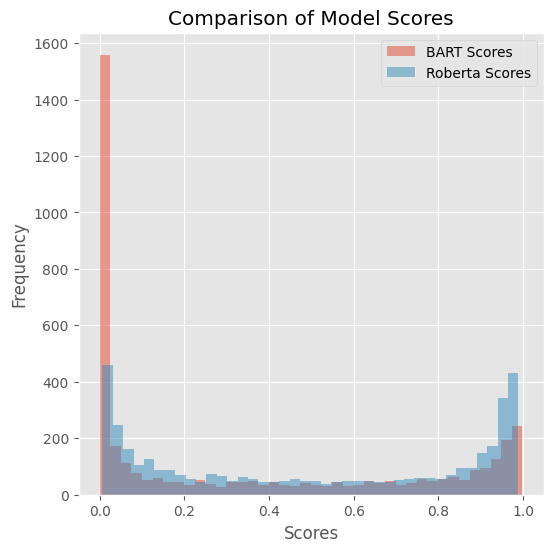

In [80]:
#extract the scores from the data frames
bart_scores = filtered_bart_df['bart_is_positive']
roberta_scores = text_with_score['model_is_positive']

#plotting the frequency using histograms
plt.figure(figsize=(6, 6))
plt.hist(bart_scores, bins=40, alpha=0.5, label='BART Scores')
plt.hist(roberta_scores, bins=40, alpha=0.5, label='Roberta Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Comparison of Model Scores')
plt.legend()
plt.show()

## evaluation metrics

In [81]:
#Checking other evaluation metrics
#It would be really nice to see the metrics for the provided model to compare with the trained roberta base model

In [82]:
import json
f=open('roberta_model/metric.json')
roberta = json.load(f)

In [83]:
roberta

{'eval_loss': 0.385017991065979,
 'eval_accuracy': 0.8357638888888889,
 'eval_precision': 0.8358819723948089,
 'eval_recall': 0.8357638888888889,
 'eval_f1': 0.8357494528056394,
 'eval_runtime': 18.7066,
 'eval_samples_per_second': 153.956,
 'eval_steps_per_second': 2.406,
 'epoch': 3.0}